# Task A - single subject

## Notebook setup
This first cell contains the parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- label: index of feature column to be selected to perform activity detection, between [0,6]. The default value for task B is 6;
- folder: directory name where '.mat' files are stored;
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

In [1]:
subject = 1
label = 0
folder = "../data/full/"
window_size = 15
stride = 5
GPU = True

In [2]:
import preprocessing
import models
import utils
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical

C:\Users\Riccardo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In the following cell, we make use of some functions of Keras which have been removed, but of which the code is still available at https://github.com/keras-team/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7. These are used to evaulate the f1 score during training on batches of data: this is only an approximation though, which is the reason why they have been removed.

In [3]:
import os
if not(os.path.exists("./data")):
    os.mkdir("./data")

# One-shot classification
Here classification is performed with null class.
### Preprocessing

In [4]:
X_train, Y_train, X_test, Y_test, n_features, n_classes, class_weights = preprocessing.loadData(subject=subject,
                                                                                                label=label,
                                                                                                folder=folder,
                                                                                                window_size=window_size,
                                                                                                stride=stride,
                                                                                                make_binary=False,
                                                                                                null_class=True,
                                                                                                print_info=False)

Y_train and Y_test contain the correct labels for each signals window. Y_test in particular will be used to evaluate predictions for both this (one-shot) and the two-steps models. For this reason it is here saved with a different name, to avoid having it being overwritten later.

In [5]:
Y_test_true = Y_test

### Model

In [6]:
oneshot_model = models.Convolutional1DRecurrent((window_size, n_features), n_classes, GPU=GPU, print_info=True)

oneshot_model.compile(optimizer = Adam(lr=0.001),
                      loss = "categorical_crossentropy", 
                      metrics = ["accuracy"])

checkpointer = ModelCheckpoint(filepath='./data/model_AOS_1.hdf5', verbose=1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.15, patience=5, min_lr=0.00001, verbose=1)

### Training

In [7]:
oneshot_model.fit(x = X_train, 
                  y = to_categorical(Y_train),
                  epochs = 20,
                  batch_size = 128,
                  verbose = 1,
                  callbacks=[checkpointer, lr_reducer],
                  validation_data=(X_test, to_categorical(Y_test)),
                  class_weight=class_weights)

Train on 31422 samples, validate on 11504 samples
Epoch 1/20
31422/31422 [==============================] - 8s 254us/step - loss: 0.4101 - acc: 0.8393 - val_loss: 0.3367 - val_acc: 0.8873

Epoch 00001: val_loss improved from inf to 0.33669, saving model to ./data/model_AOS_1.hdf5
Epoch 2/20
31422/31422 [==============================] - 5s 144us/step - loss: 0.2570 - acc: 0.8980 - val_loss: 0.3171 - val_acc: 0.8785

Epoch 00002: val_loss improved from 0.33669 to 0.31714, saving model to ./data/model_AOS_1.hdf5
Epoch 3/20
31422/31422 [==============================] - 5s 144us/step - loss: 0.2085 - acc: 0.9171 - val_loss: 0.3859 - val_acc: 0.8700

Epoch 00003: val_loss did not improve
Epoch 4/20
31422/31422 [==============================] - 5s 148us/step - loss: 0.1783 - acc: 0.9297 - val_loss: 0.3685 - val_acc: 0.8707

Epoch 00004: val_loss did not improve
Epoch 5/20
31422/31422 [==============================] - 5s 147us/step - loss: 0.1560 - acc: 0.9385 - val_loss: 0.3923 - val_acc:

### Evaluation - passare class_weights a class report

In [8]:
Y_pred = oneshot_model.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
score_OS = f1_score(Y_test, Y_pred, average='weighted')
print("Weighted f1-score:", score_OS)

             precision    recall  f1-score   support

          0       0.92      0.81      0.86      2039
          1       0.92      0.86      0.89      3958
          2       0.70      0.84      0.76      2332
          3       0.98      0.99      0.98      2733
          4       0.93      0.84      0.88       442

avg / total       0.89      0.88      0.88     11504

Weighted f1-score: 0.8812433764336887


In [9]:
oneshot_model_best = load_model('./data/model_AOS_1.hdf5')

Y_pred = oneshot_model_best.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
score_OS_best = f1_score(Y_test, Y_pred, average='weighted')
print("Weighted f1-score:", score_OS_best)
if score_OS_best > score_OS:
    score_OS = score_OS_best

             precision    recall  f1-score   support

          0       0.96      0.79      0.87      2039
          1       0.90      0.84      0.87      3958
          2       0.70      0.89      0.78      2332
          3       0.98      0.99      0.99      2733
          4       0.89      0.85      0.87       442

avg / total       0.89      0.88      0.88     11504

Weighted f1-score: 0.8805286132681011


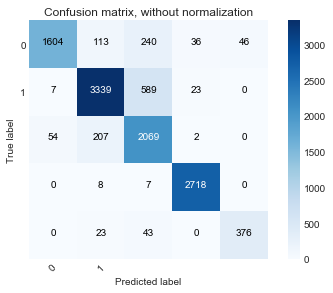

In [10]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Two-steps classification
## Activity detection
This model performs a binary classification.
### Preprocessing

In [11]:
X_train, Y_train, X_test, Y_test, n_features, n_classes, class_weights = preprocessing.loadData(subject=subject,
                                                                                                label=label,
                                                                                                folder=folder,
                                                                                                window_size=window_size,
                                                                                                stride=stride,
                                                                                                make_binary=True,
                                                                                                null_class=True,
                                                                                                print_info=False)

### Model

In [12]:
detection_model = models.Convolutional1DRecurrent((window_size, n_features), n_classes, GPU=GPU, print_info=False)

detection_model.compile(optimizer = Adam(lr=0.001),
                        loss = "categorical_crossentropy", 
                        metrics = ["accuracy"])

checkpointer = ModelCheckpoint(filepath='./data/model_ATSD_1.hdf5', verbose=1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.15, patience=5, min_lr=0.00001, verbose=1)

### Training

In [13]:
detection_model.fit(x = X_train, 
                    y = to_categorical(Y_train), 
                    epochs = 20, 
                    batch_size = 128,
                    verbose = 1,
                    callbacks=[checkpointer, lr_reducer],
                    validation_data=(X_test, to_categorical(Y_test)),
                    class_weight=class_weights)

Train on 31422 samples, validate on 11504 samples
Epoch 1/20
31422/31422 [==============================] - 6s 188us/step - loss: 0.1252 - acc: 0.9585 - val_loss: 0.1979 - val_acc: 0.9139

Epoch 00001: val_loss improved from inf to 0.19790, saving model to ./data/model_ATSD_1.hdf5
Epoch 2/20
31422/31422 [==============================] - 5s 145us/step - loss: 0.0610 - acc: 0.9785 - val_loss: 0.1650 - val_acc: 0.9511

Epoch 00002: val_loss improved from 0.19790 to 0.16498, saving model to ./data/model_ATSD_1.hdf5
Epoch 3/20
31422/31422 [==============================] - 5s 145us/step - loss: 0.0449 - acc: 0.9844 - val_loss: 0.1385 - val_acc: 0.9506

Epoch 00003: val_loss improved from 0.16498 to 0.13846, saving model to ./data/model_ATSD_1.hdf5
Epoch 4/20
31422/31422 [==============================] - 5s 145us/step - loss: 0.0336 - acc: 0.9882 - val_loss: 0.1810 - val_acc: 0.9465

Epoch 00004: val_loss did not improve
Epoch 5/20
31422/31422 [==============================] - 5s 146us/st

### Evaluation

In [14]:
Y_pred = detection_model.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
score_TSD = f1_score(Y_test, Y_pred, average='weighted')
print("Weighted f1-score:", score_TSD)

             precision    recall  f1-score   support

          0       0.94      0.82      0.87      2039
          1       0.96      0.99      0.97      9465

avg / total       0.96      0.96      0.96     11504

Weighted f1-score: 0.95633852547153


In [15]:
detection_model_best = load_model('./data/model_ATSD_1.hdf5')

Y_pred = detection_model_best.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
score_TSD_best = f1_score(Y_test, Y_pred, average='weighted')
print("Weighted f1-score:", score_TSD_best)
if score_TSD_best > score_TSD:
    score_TSD = score_TSD_best

             precision    recall  f1-score   support

          0       0.92      0.84      0.88      2039
          1       0.97      0.98      0.98      9465

avg / total       0.96      0.96      0.96     11504

Weighted f1-score: 0.9585971816870955


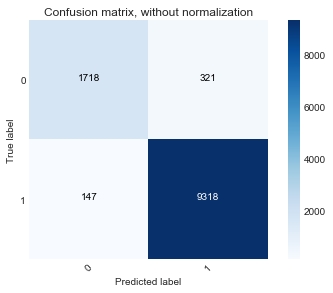

In [16]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [17]:
Y_pred_d = Y_pred

In [18]:
np.sum(Y_pred_d)

9639

In [19]:
Y_pred_d.shape

(11504,)

## Activity classification

In [20]:
X_train, Y_train, X_test, Y_test, n_features, n_classes, class_weights = preprocessing.loadData(subject=subject,
                                                                                                label=label,
                                                                                                folder=folder,
                                                                                                window_size=window_size,
                                                                                                stride=stride,
                                                                                                make_binary=False,
                                                                                                null_class=False,
                                                                                                print_info=False)

### Model

In [21]:
classification_model = models.Convolutional1DRecurrent((window_size, n_features), n_classes, GPU=GPU, print_info=False)

classification_model.compile(optimizer = Adam(lr=0.001),
                             loss = "categorical_crossentropy", 
                             metrics = ["accuracy"])

checkpointer = ModelCheckpoint(filepath='./data/model_ATSC_1.hdf5', verbose=1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.15, patience=5, min_lr=0.00001, verbose=1)

### Training

In [22]:
classification_model.fit(x = X_train,
                         y = to_categorical(Y_train), 
                         epochs = 20, 
                         batch_size = 128,
                         verbose = 1,
                         callbacks=[checkpointer],
                         validation_data=(X_test, to_categorical(Y_test)),
                         class_weight=class_weights)

Train on 27948 samples, validate on 9465 samples
Epoch 1/20
27948/27948 [==============================] - 6s 202us/step - loss: 0.3177 - acc: 0.8665 - val_loss: 0.2700 - val_acc: 0.9231

Epoch 00001: val_loss improved from inf to 0.27001, saving model to ./data/model_ATSC_1.hdf5
Epoch 2/20
27948/27948 [==============================] - 4s 145us/step - loss: 0.2047 - acc: 0.9151 - val_loss: 0.2645 - val_acc: 0.9193

Epoch 00002: val_loss improved from 0.27001 to 0.26449, saving model to ./data/model_ATSC_1.hdf5
Epoch 3/20
27948/27948 [==============================] - 4s 146us/step - loss: 0.1736 - acc: 0.9289 - val_loss: 0.2483 - val_acc: 0.9174

Epoch 00003: val_loss improved from 0.26449 to 0.24829, saving model to ./data/model_ATSC_1.hdf5
Epoch 4/20
27948/27948 [==============================] - 4s 146us/step - loss: 0.1492 - acc: 0.9384 - val_loss: 0.2373 - val_acc: 0.9312

Epoch 00004: val_loss improved from 0.24829 to 0.23735, saving model to ./data/model_ATSC_1.hdf5
Epoch 5/20


### Evaluation

In [23]:
Y_pred = classification_model.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
score_TSC = f1_score(Y_test, Y_pred, average='weighted')
print("Weighted f1-score:", score_TSC)

             precision    recall  f1-score   support

          0       0.94      0.87      0.90      3958
          1       0.78      0.90      0.84      2332
          2       0.99      1.00      1.00      2733
          3       1.00      0.85      0.92       442

avg / total       0.92      0.91      0.91      9465

Weighted f1-score: 0.914329502844986


In [25]:
classification_model_best = load_model('./data/model_ATSC_1.hdf5')

Y_pred = classification_model_best.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
score_TSC_best = f1_score(Y_test, Y_pred, average='weighted')
print("Weighted f1-score:", score_TSC_best)
if score_TSC_best > score_TSC:
    score_TSC = score_TSC_best

             precision    recall  f1-score   support

          0       0.93      0.91      0.92      3958
          1       0.86      0.90      0.88      2332
          2       0.99      1.00      0.99      2733
          3       1.00      0.85      0.92       442

avg / total       0.93      0.93      0.93      9465

Weighted f1-score: 0.9312764290620789


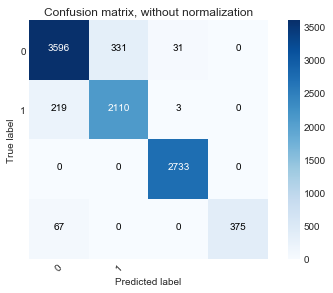

In [26]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

## Cascade of detection and classification
The labels that have to be used for assessment are saved in Y_test_true. The labels predicted by the detection_model are saved instead in Y_pred_d.

In [27]:
print(Y_test_true.shape, Y_pred_d.shape)

(11504,) (11504,)


In [28]:
X_train, Y_train, X_test, Y_test, n_features, n_classes, class_weights = preprocessing.loadData(subject=subject,
                                                                                                label=label,
                                                                                                folder=folder,
                                                                                                window_size=window_size,
                                                                                                stride=stride,
                                                                                                make_binary=True,
                                                                                                null_class=True,
                                                                                                print_info=False)

In [29]:
mask = (Y_pred_d == 1)
X_detected = X_test[mask, :, :]
Y_pred_c = classification_model_best.predict_classes(X_detected)
Y_pred_d[mask] = Y_pred_c

In [30]:
print(classification_report(Y_test_true, Y_pred_d))
print("Weighted f1-score:", f1_score(Y_test_true, Y_pred_d, average='weighted'))

             precision    recall  f1-score   support

          0       0.31      0.87      0.45      2039
          1       0.13      0.08      0.10      3958
          2       0.00      0.00      0.00      2332
          3       0.00      0.00      0.00      2733
          4       0.00      0.00      0.00       442

avg / total       0.10      0.18      0.12     11504

Weighted f1-score: 0.11551761533956331


C:\Users\Riccardo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Riccardo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


One-shot classification instead had:

In [31]:
X_train, Y_train, X_test, Y_test, n_features, n_classes, class_weights = preprocessing.loadData(subject=subject,
                                                                                                label=label,
                                                                                                folder=folder,
                                                                                                window_size=window_size,
                                                                                                stride=stride,
                                                                                                make_binary=False,
                                                                                                null_class=True,
                                                                                                print_info=False)

In [32]:
oneshot_model_best = load_model('./data/model_AOS_1.hdf5')

Y_pred = oneshot_model_best.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
print("Weighted f1-score:", f1_score(Y_test, Y_pred, average='weighted'))

             precision    recall  f1-score   support

          0       0.96      0.79      0.87      2039
          1       0.90      0.84      0.87      3958
          2       0.70      0.89      0.78      2332
          3       0.98      0.99      0.99      2733
          4       0.89      0.85      0.87       442

avg / total       0.89      0.88      0.88     11504

Weighted f1-score: 0.8805286132681011


Save results to numpy array

In [33]:
np.save("./data/results_"+str(subject), [score_OS, score_TSD, score_TSC])

# end